In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

ksdir = '/home/anverdie/Data_Ephys/D5_220916_182221'
fs = 20000
n_chan = 64

In [2]:
# Load digital input
f = open(os.path.join(ksdir, 'digitalin.dat'), 'rb') 
sd_array = np.fromfile(f, np.uint16)
f.close()

# Extract stimulus times based on digital input
sd_array_on = np.where(np.insert(np.diff(sd_array), 0, 0) == 4)[0]
sd_array_off = np.where(np.insert(np.diff(sd_array), 0, 0) == -4)[0]

# For some reason there is 26 uknown pulses at the beginning of the recording
sd_array_on = sd_array_on[26:]
sd_array_off = sd_array_off[26:]

In [3]:
# Get all spike_times
sp_times = np.load(os.path.join(ksdir,'spike_times.npy'))
sp_times = np.array([i[0] for i in sp_times])


sp_clu = np.load(os.path.join(ksdir,'spike_clusters.npy'))

clu_gp = pd.read_csv(os.path.join(ksdir,'cluster_group.tsv'), delimiter='\t')
clu_gp = clu_gp['group'].to_numpy()

usable_clusters = [i for i, clu in enumerate(clu_gp) if clu == 'good']

usable_sp = np.isin(sp_clu, usable_clusters)
sp_times = sp_times[usable_sp]
sp_clu = sp_clu[usable_sp]

idxs_clu = []
for clu in np.unique(sp_clu):
    idxs_clu.append(np.where(sp_clu == clu)[0])
n_clu = len(idxs_clu)

In [4]:
stims_ttls = np.arange(0, len(sd_array_on), 10)
first_ttls = [sd_array_on[s] for s in stims_ttls]

In [5]:
coords = [(0, 8),
(4, 8),
(6, 8),
(1, 7),
(3, 7),
(5, 7),
(7, 7),
(0, 6),
(2, 6),
(4, 6),
(6, 6),
(8, 6),
(1, 5),
(3, 5),
(5, 5),
(7, 5),
(0, 4),
(2, 4),
(4, 4),
(6, 4),
(8, 4),
(1, 3),
(3, 3),
(5, 3),
(7, 3),
(0, 2),
(2, 2),
(4, 2),
(6, 8),
(8, 2),
(1, 1),
(3, 1),
(5, 1),
(7, 1),
(2, 0),
(4, 0)]

In [6]:
# Structure of array is dict[stim_number][presentation_number] containg a number_of_cluster * spikes matrix
presentation = {}
for i, ttl in enumerate(first_ttls):
    spikes = sp_times[sp_times > ttl]
    spikes = spikes[spikes < ttl + 1000]

    presentation[i] = [(np.intersect1d(sp_times[idx_clu], spikes) - ttl)/20 for idx_clu in idxs_clu]



In [7]:
from rich.progress import track
# Creation of a matrix with shape cluster x temps x led x presentation x intensity
int_5 = np.arange(0, 2160, 4)
int_10 = np.arange(1, 2160, 4)
int_15 = np.arange(2, 2160, 4)
int_20 = np.arange(3, 2160, 4)

data = np.empty((84, 100, 36, 15, 4))

for i, inte in enumerate([int_5, int_10, int_15, int_20]):
    pres = np.array(first_ttls)[inte].reshape(15, 36)
    for p, pre in enumerate(pres):
        for l, led in enumerate(pre):
            for c, idx_clu in enumerate(idxs_clu):
                sp = sp_times[idx_clu]
                spikes = sp[(sp > led - 20000) & (sp < led + 20000)]
                
                data[c, :, l, p, i] = np.histogram(spikes - (led - 20000) , bins=100)[0]

np.save('data.npy', data)
            

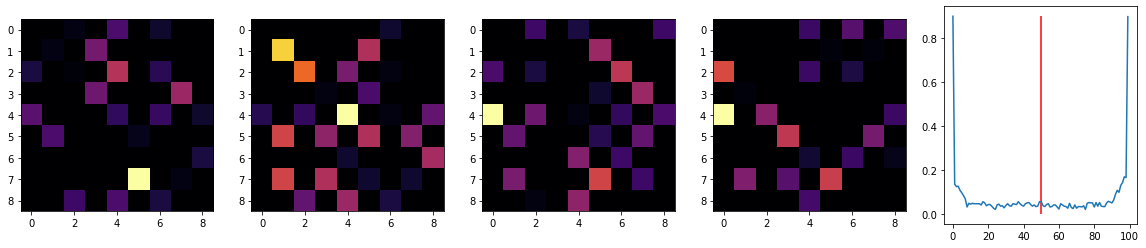

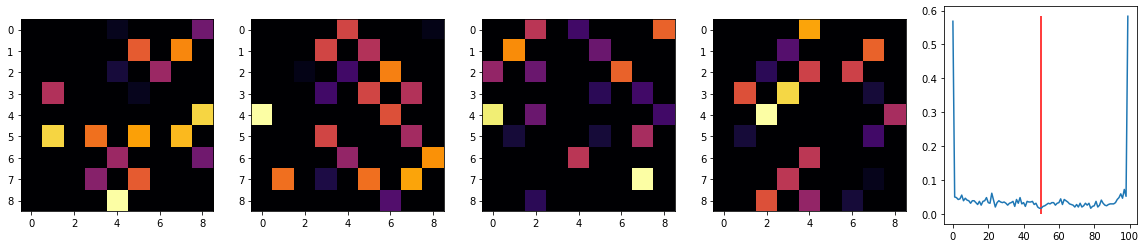

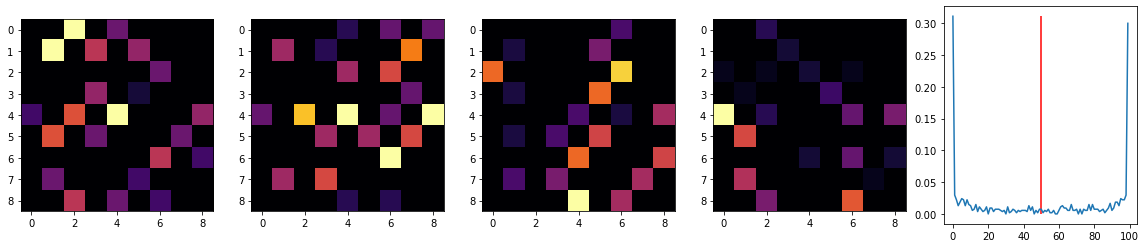

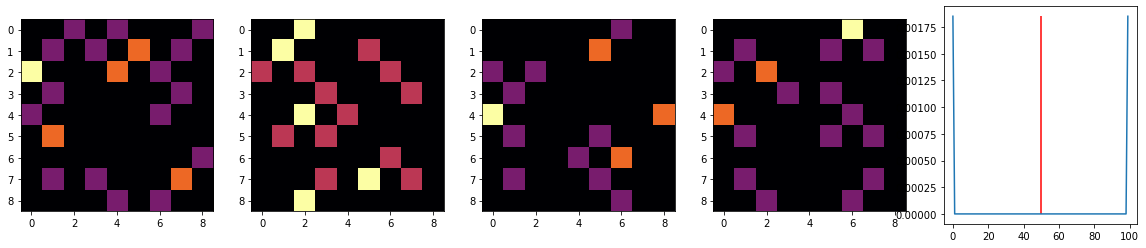

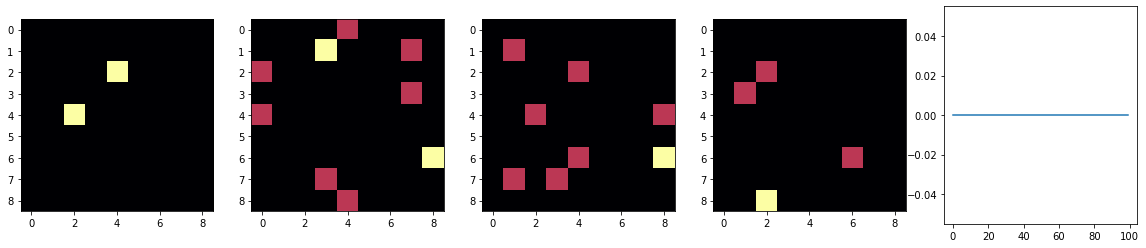

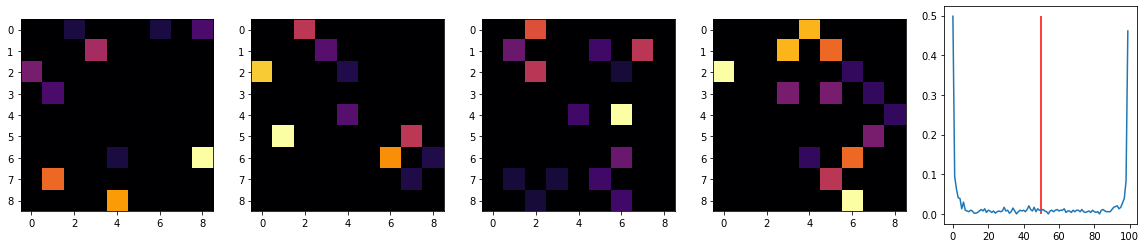

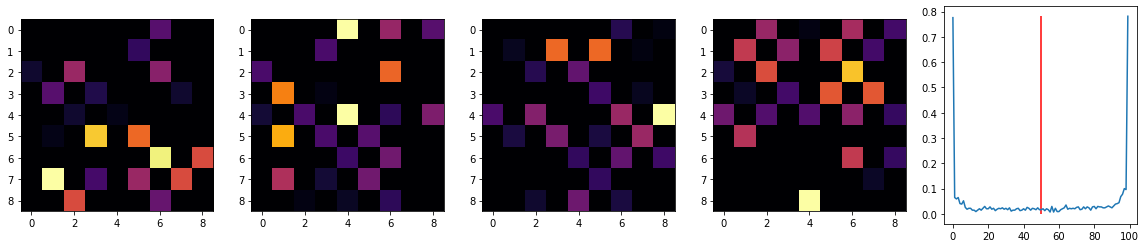

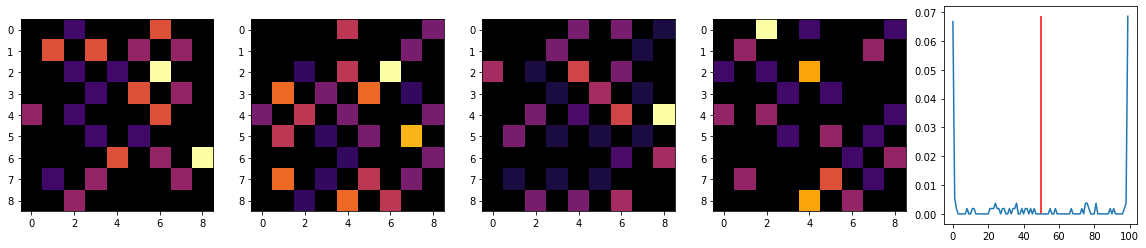

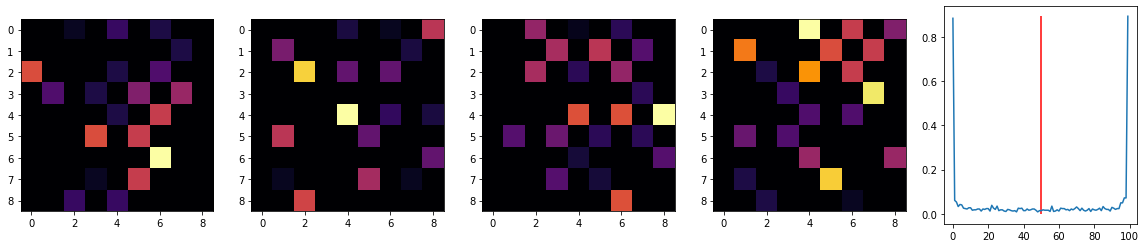

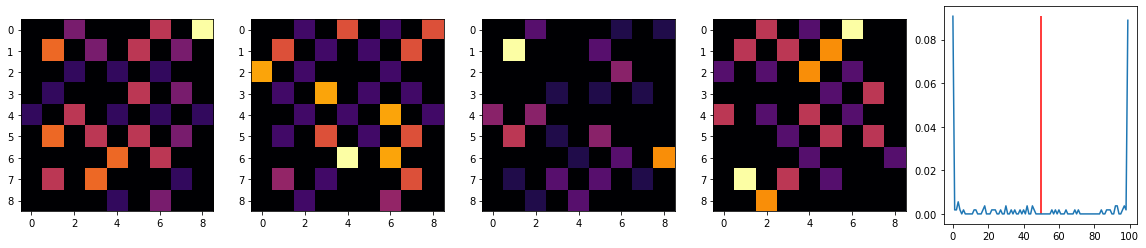

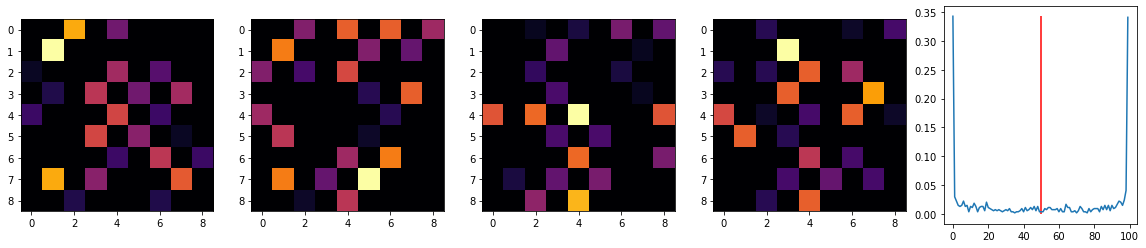

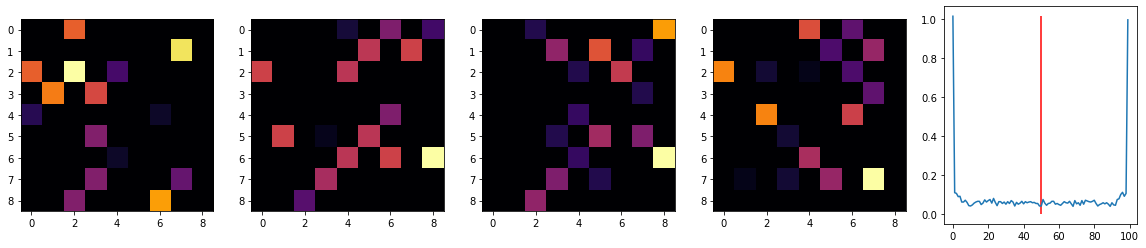

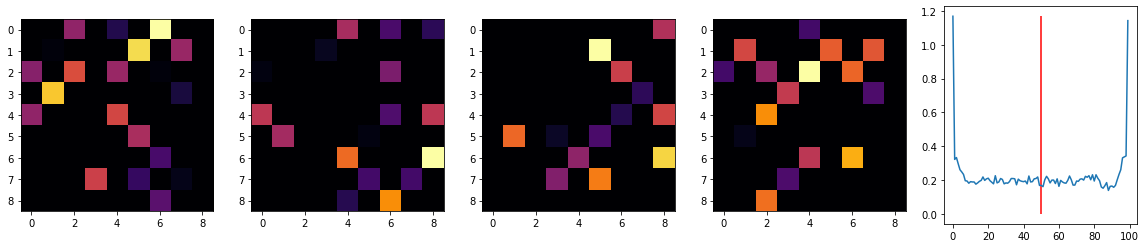

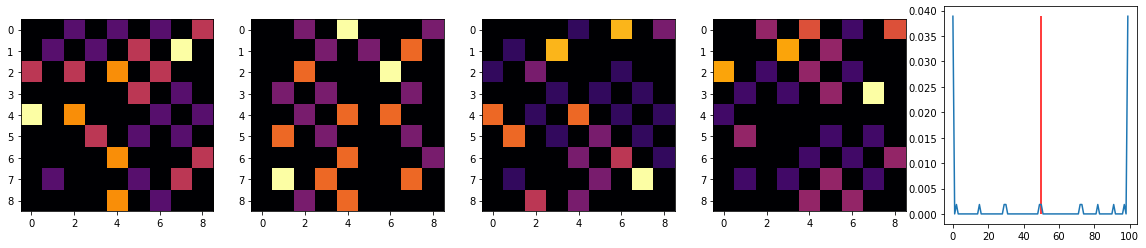

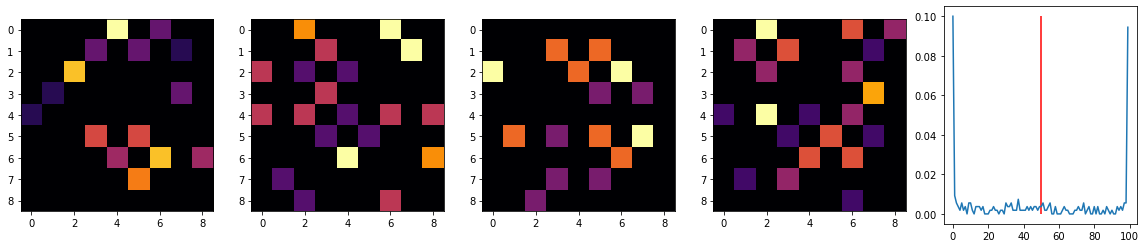

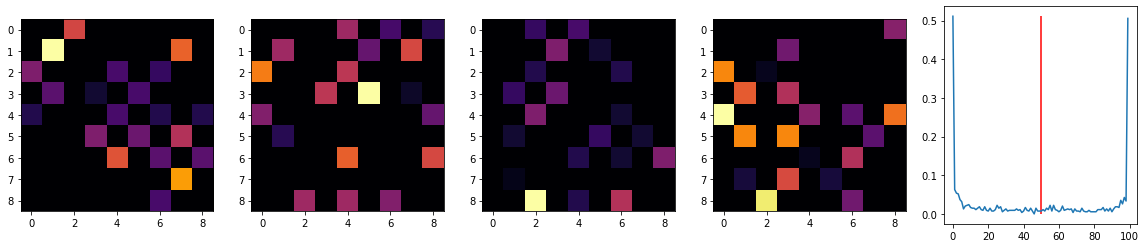

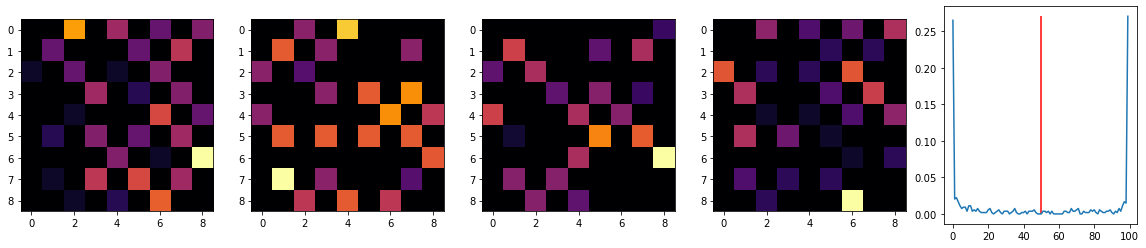

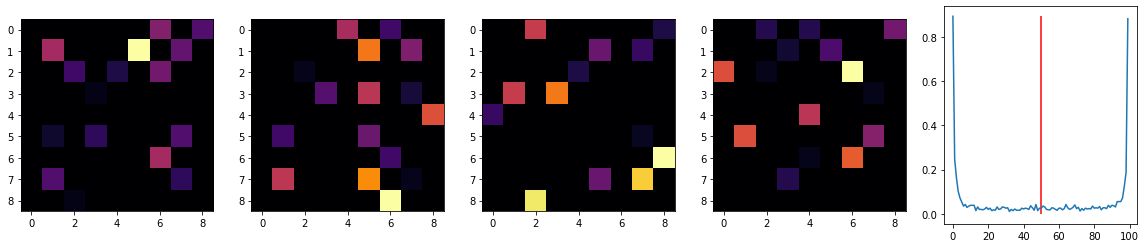

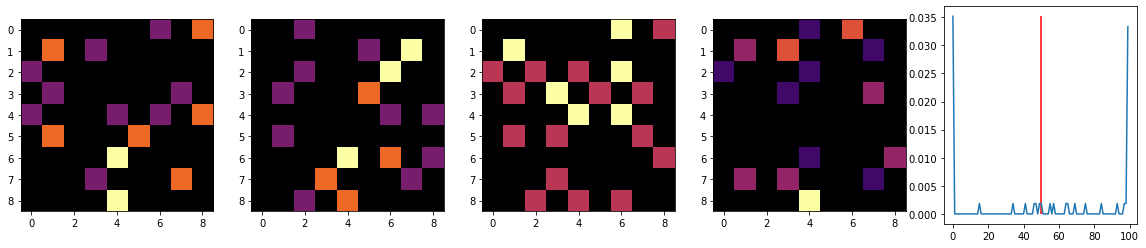

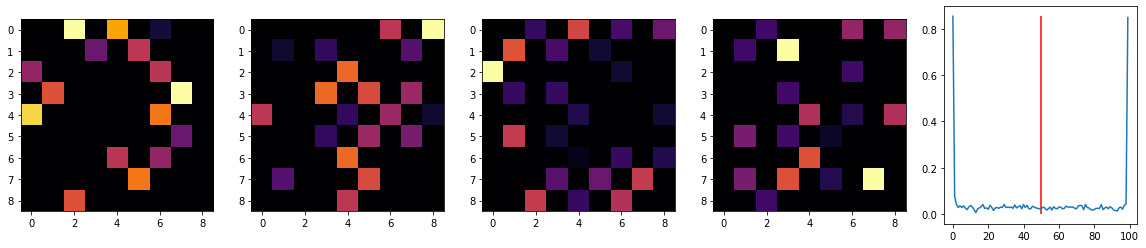

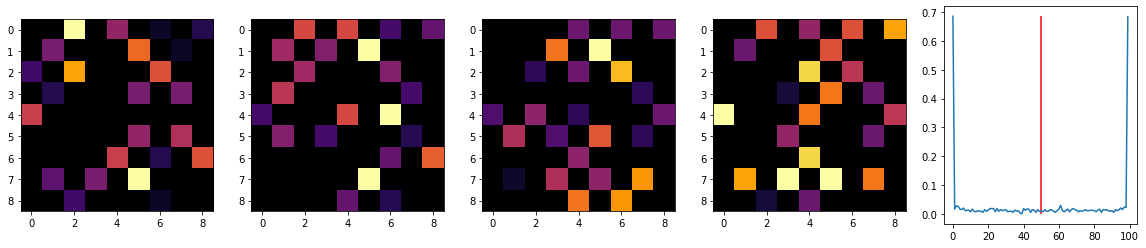

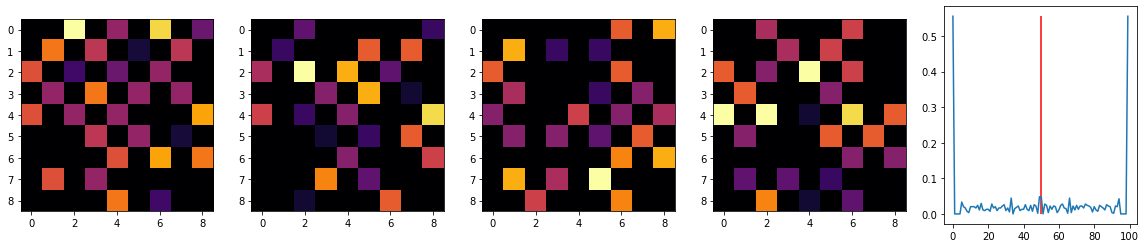

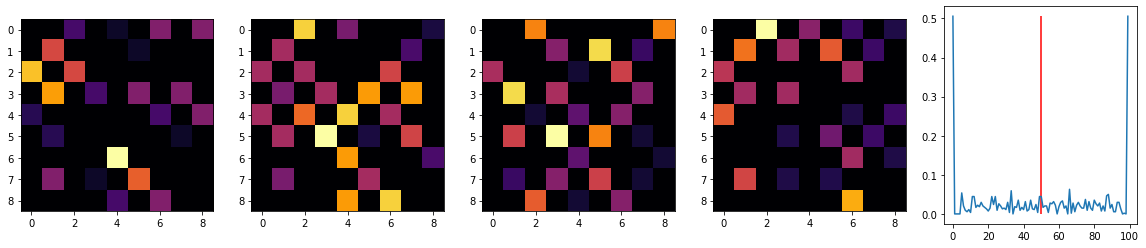

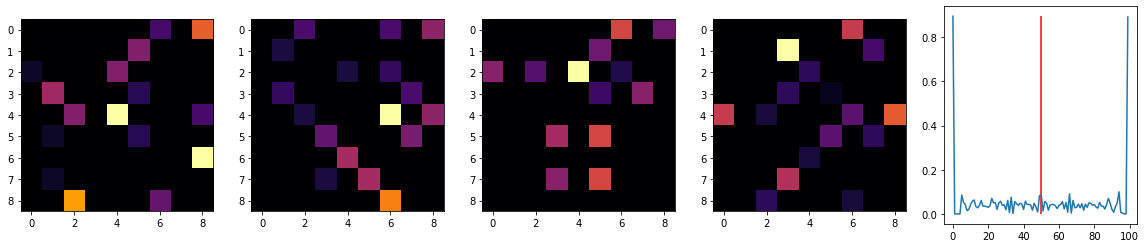

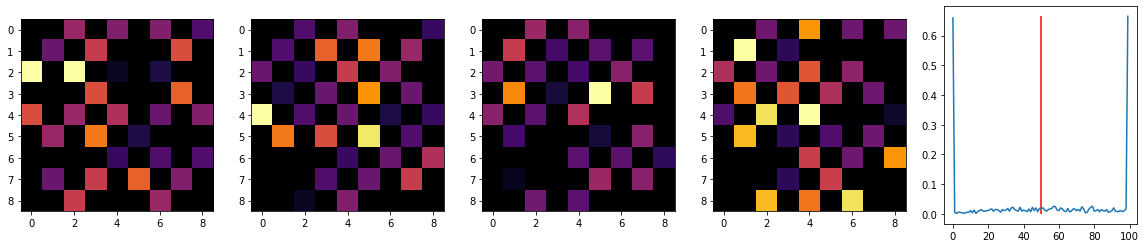

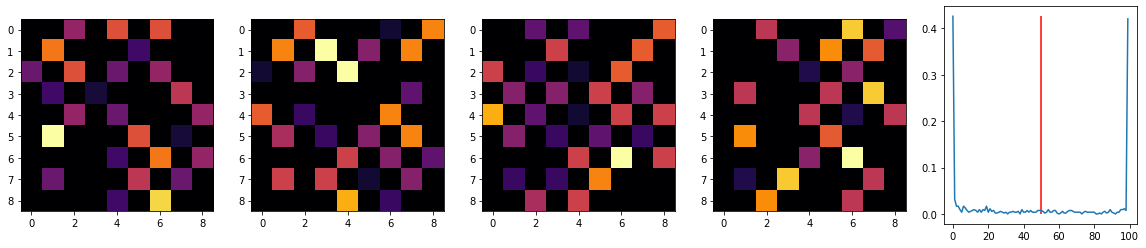

KeyboardInterrupt: 

<Figure size 1440x288 with 0 Axes>

In [8]:
datar = np.load('data.npy')
average_data = np.mean(datar, axis=3)

for cluster in average_data:
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    grids = []
    for i, intens in enumerate(np.rollaxis(cluster, 2)):
        grid = np.zeros((9, 9))
        leds = np.mean(intens[50:, :] - intens[:50, :], axis=0)
        psth = np.mean(intens, axis=1)
        
        psth[50] = psth[49]
        
        psth = psth[0:100]
        if i == 3:
            axs[4].plot(psth)
            axs[4].vlines(50, 0, np.max(psth), color='red')

        for c, l in zip(coords, leds):
            grid[c[0], c[1]] = l
        grids.append(grid)
        axs[i].imshow(grid, cmap='inferno', vmin=0, vmax=np.max(grid))        
    

    plt.show()
    plt.close()   


    

In [ ]:
# Structure of array is dict[stim_number][presentation_number] containg a number_of_cluster * spikes matrix
baselines = {}
for i, ttl in enumerate(first_ttls):
    spikes = sp_times[sp_times > ttl - 10000]
    spikes = spikes[spikes < ttl]

    baselines[i] = [(np.intersect1d(sp_times[idx_clu], spikes) - ttl)/20 for idx_clu in idxs_clu]

print(len(baselines))


2160


In [ ]:
# Averageover all presentations
n_pres = 15
n_stim_pre_pres = 144
n_chan = 65

mean_pres = {}
for i in range(n_stim_pre_pres):
    mean_pres[i] = {}
    for chan in range(n_chan):
        mean_pres[i][chan] = np.array([])


for p in range(n_pres):
    for s in range(n_stim_pre_pres):
        for chan in range(len(presentation[0])):
            mean_pres[s][chan] = np.append(mean_pres[s][chan], presentation[p*144+s][chan])

KeyError: 65

In [ ]:
a = np.arange(540)
print(a.reshape(15, 36))

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35]
 [ 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71]
 [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
 [108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
 [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215]
 [216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
  234 235 236 237 238 239 240 24

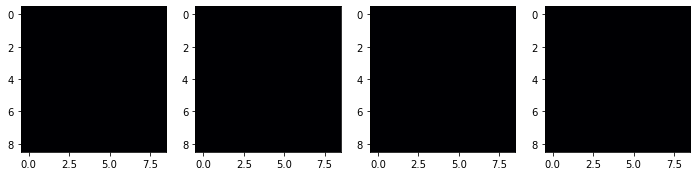

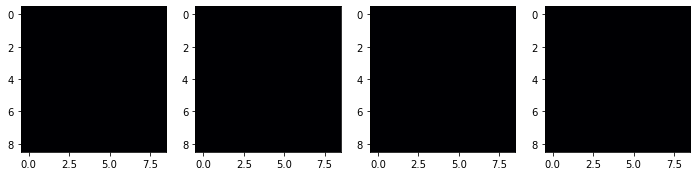

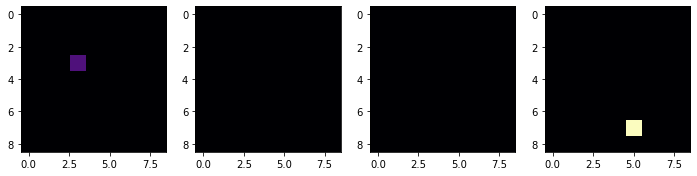

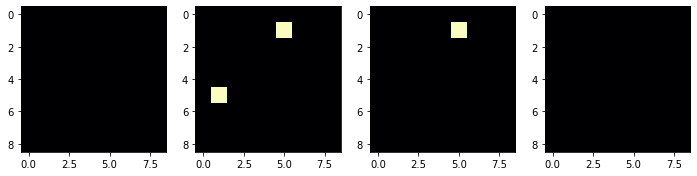

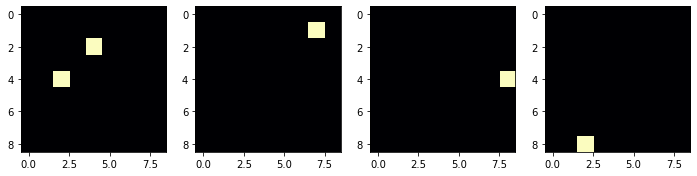

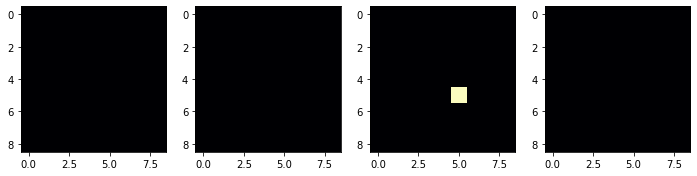

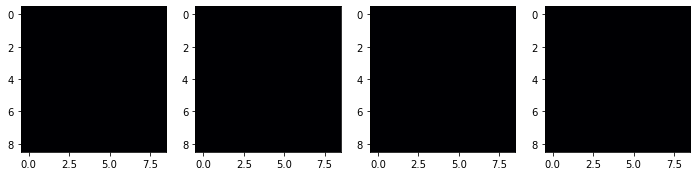

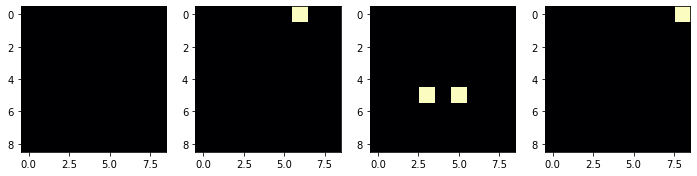

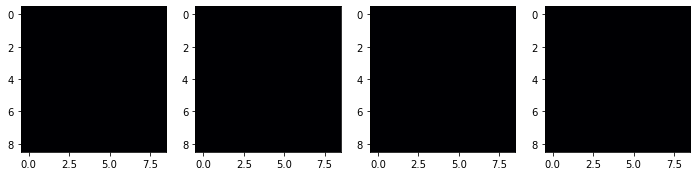

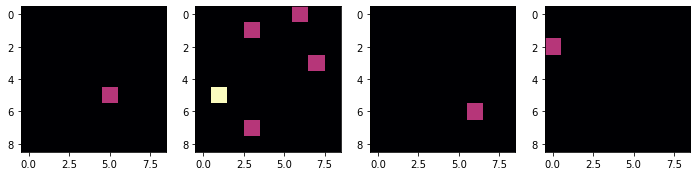

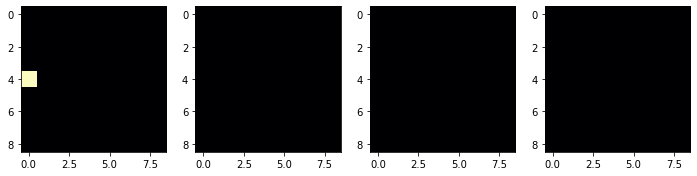

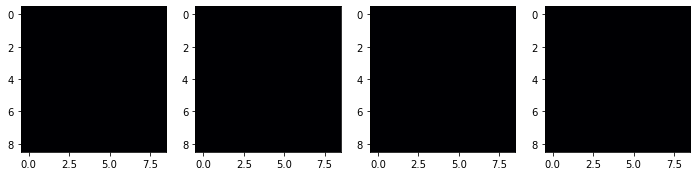

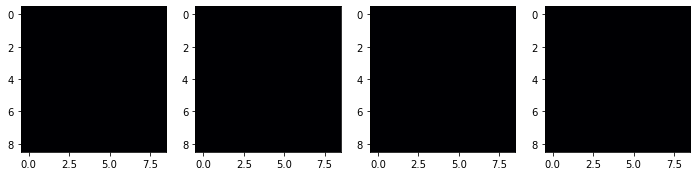

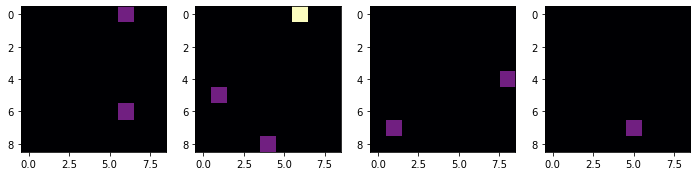

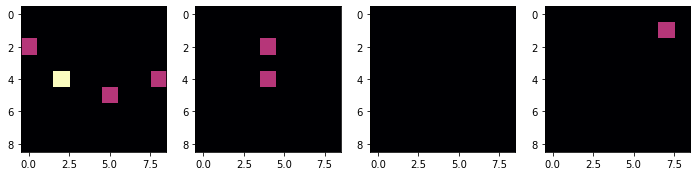

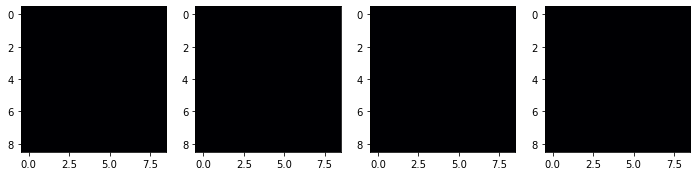

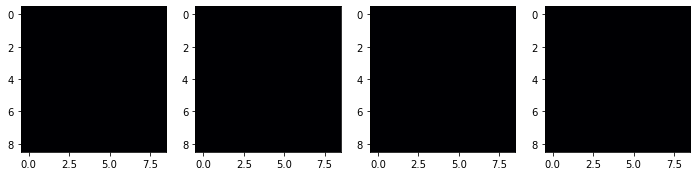

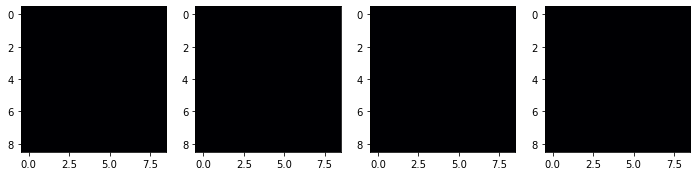

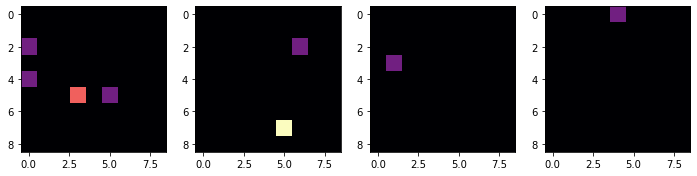

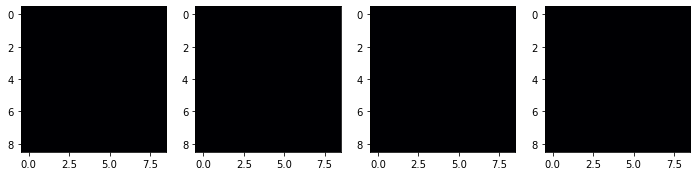

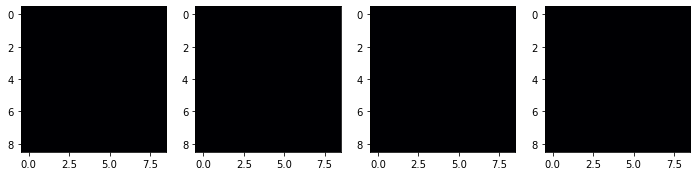

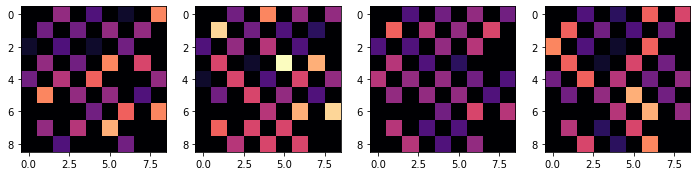

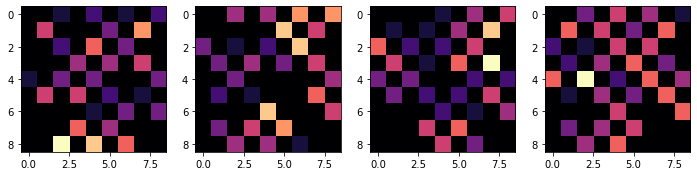

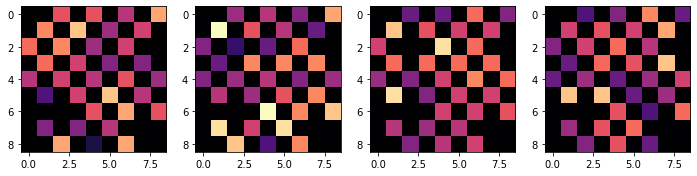

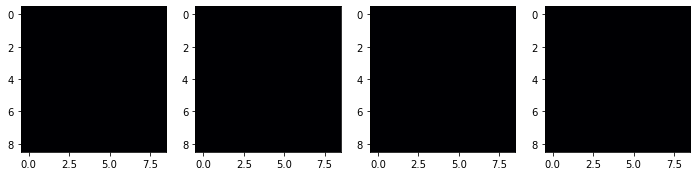

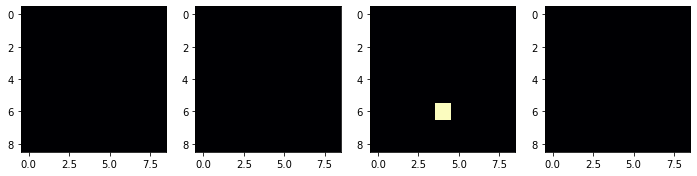

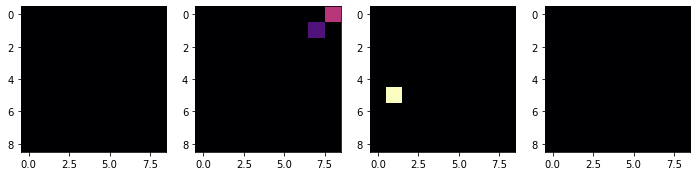

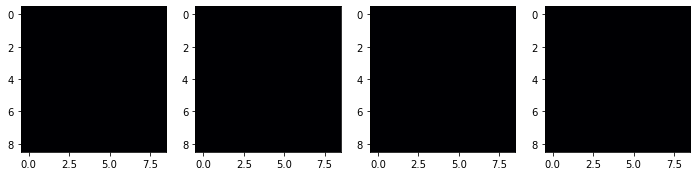

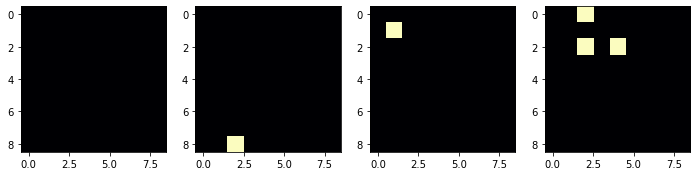

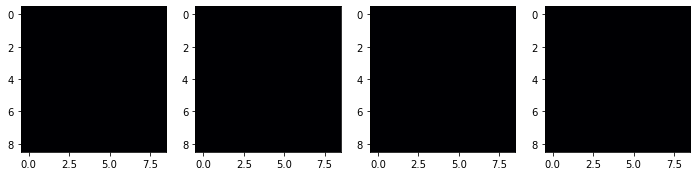

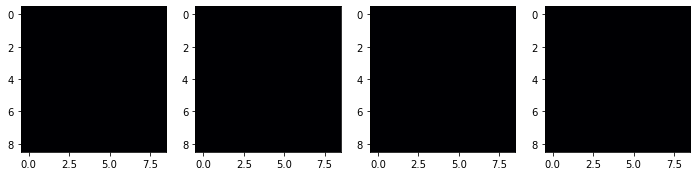

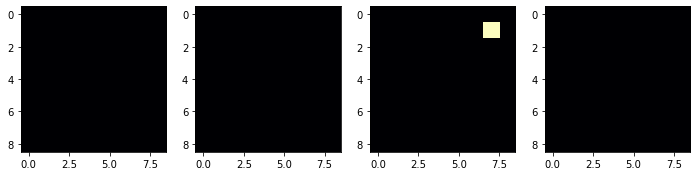

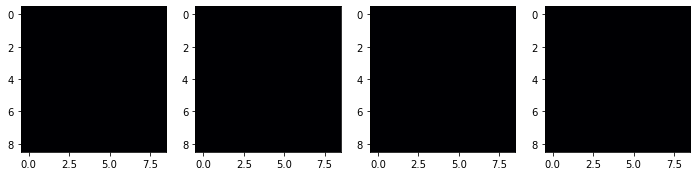

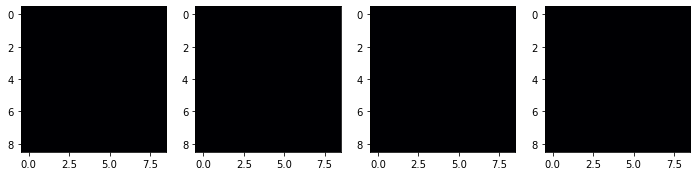

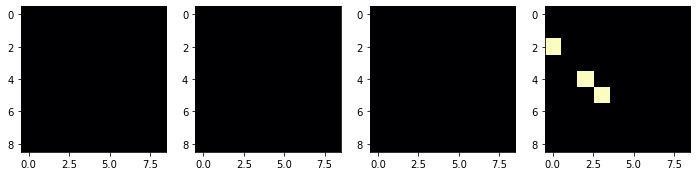

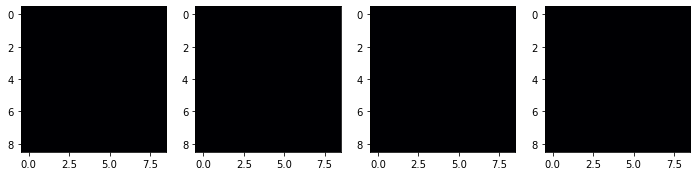

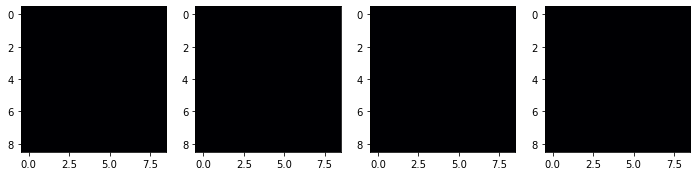

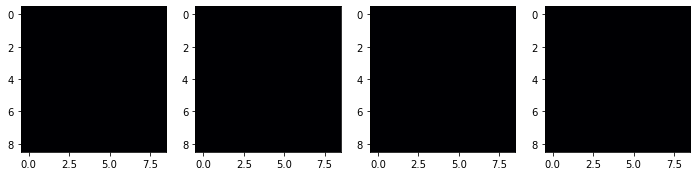

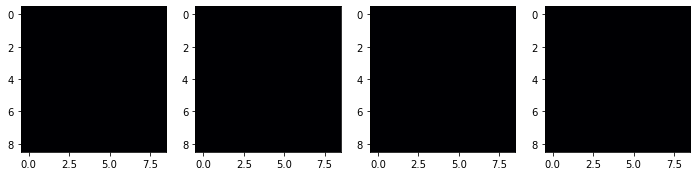

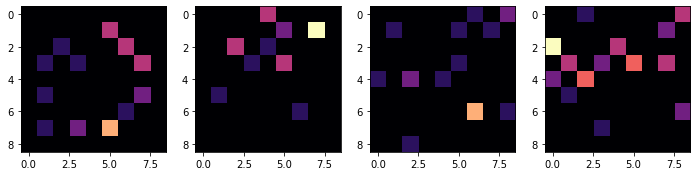

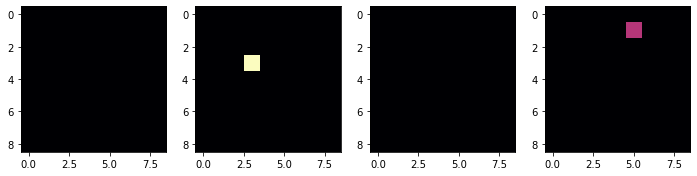

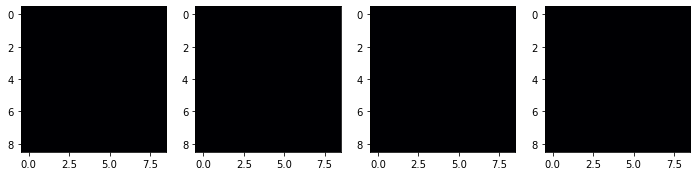

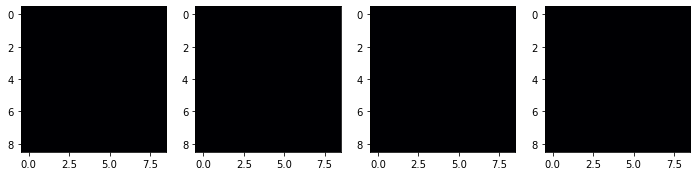

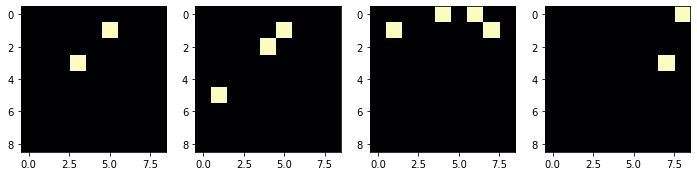

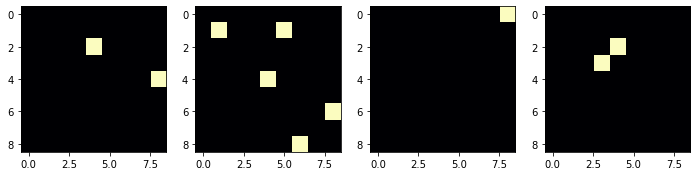

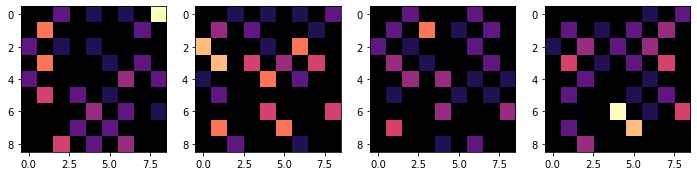

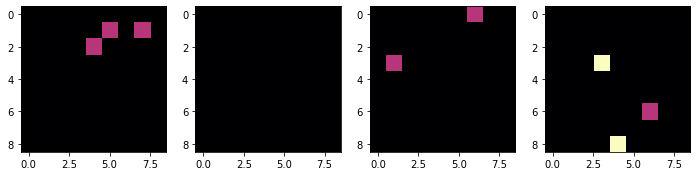

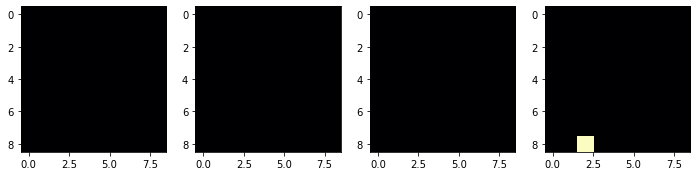

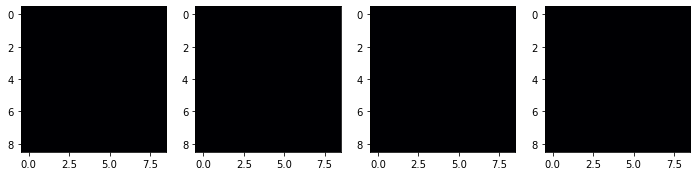

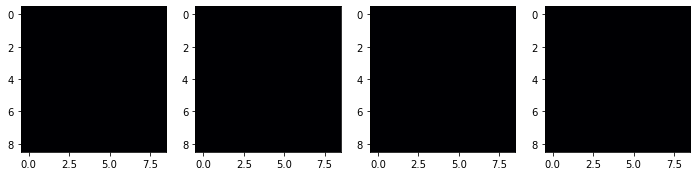

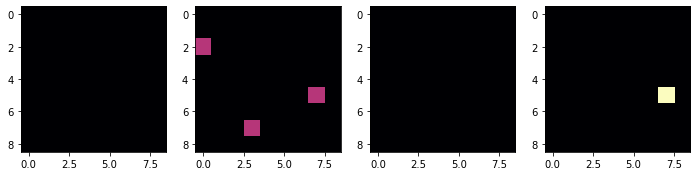

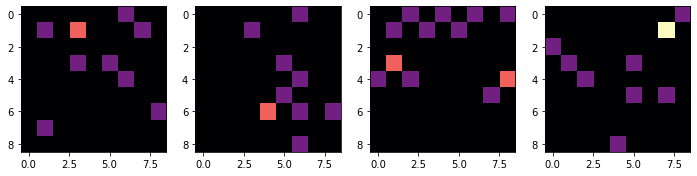

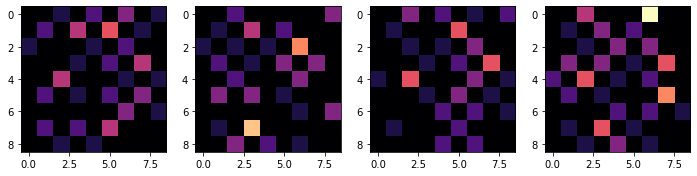

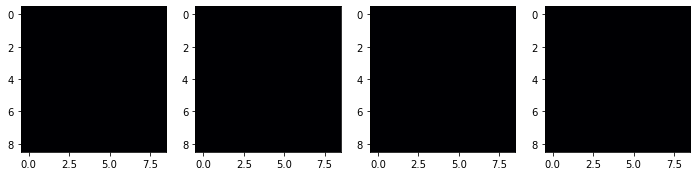

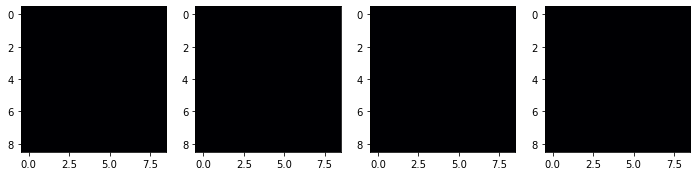

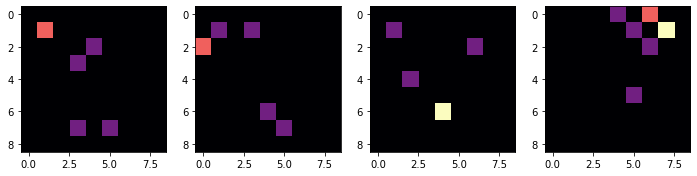

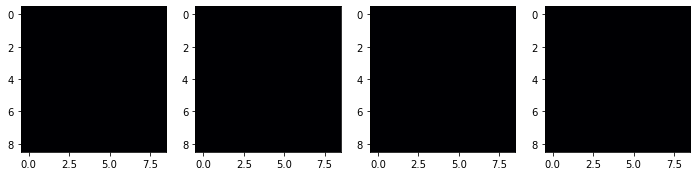

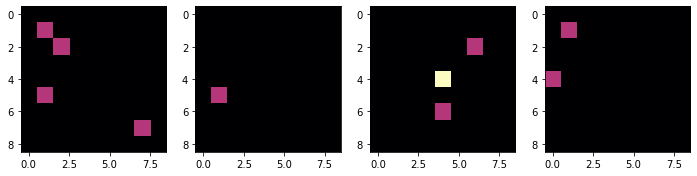

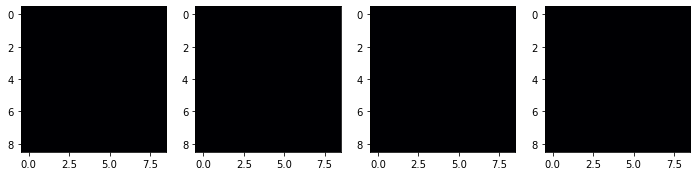

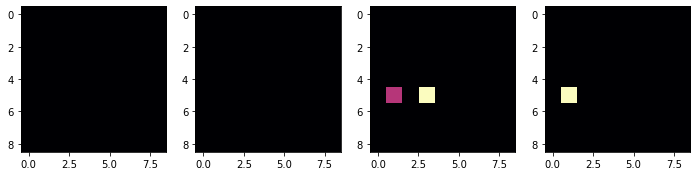

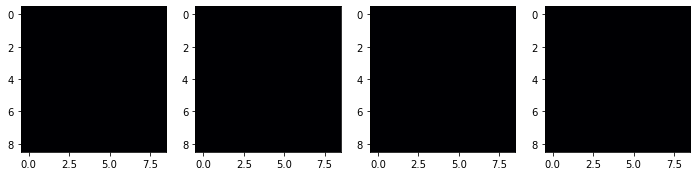

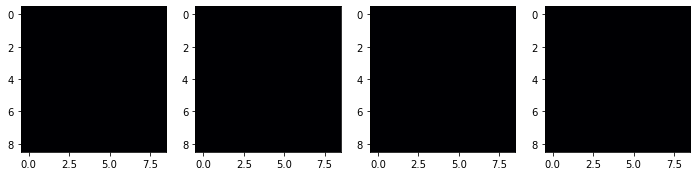

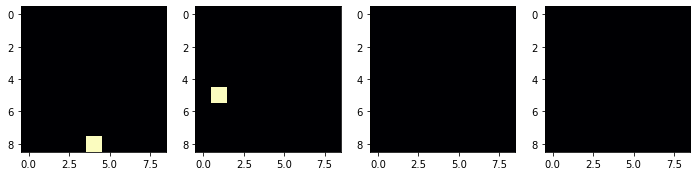

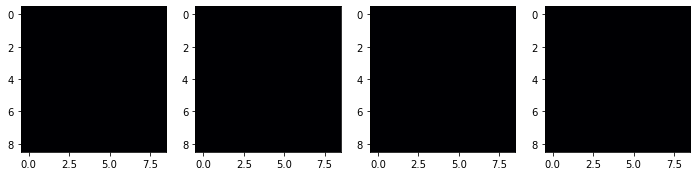

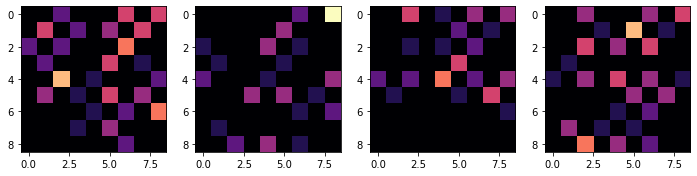

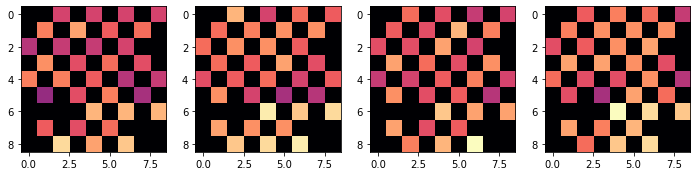

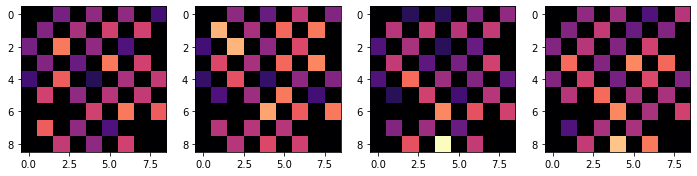

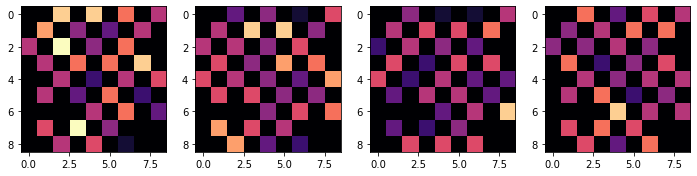

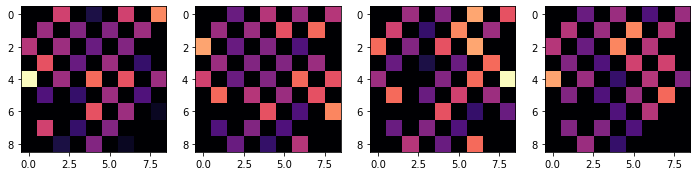

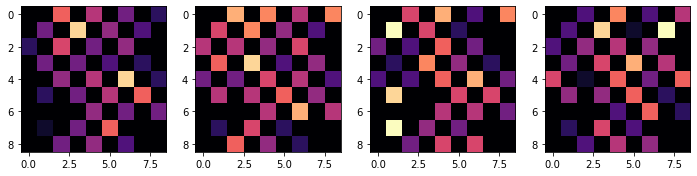

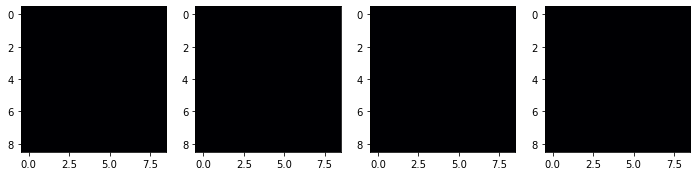

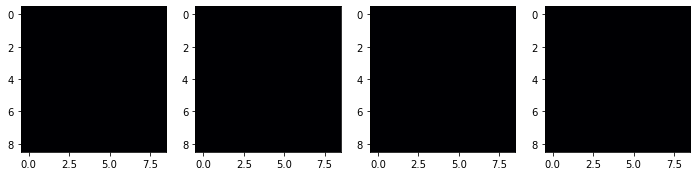

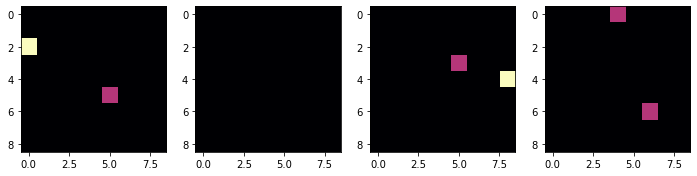

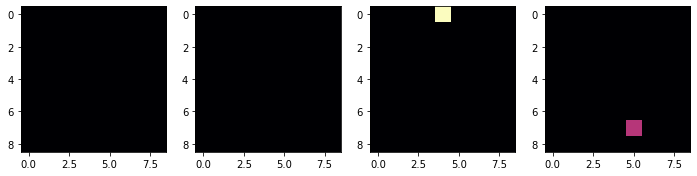

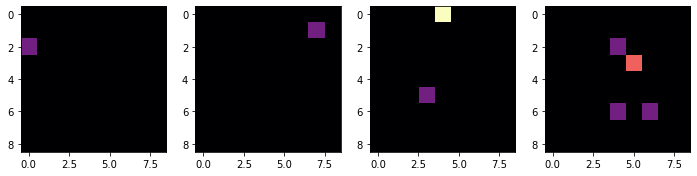

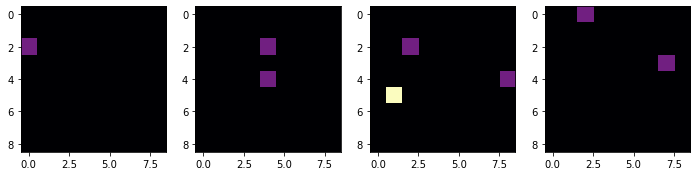

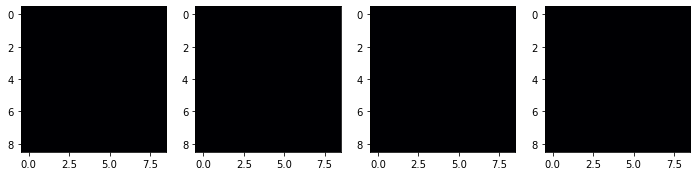

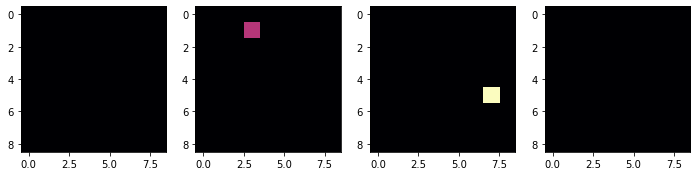

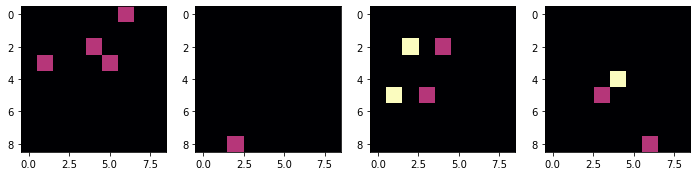

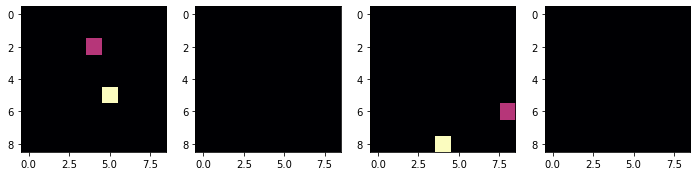

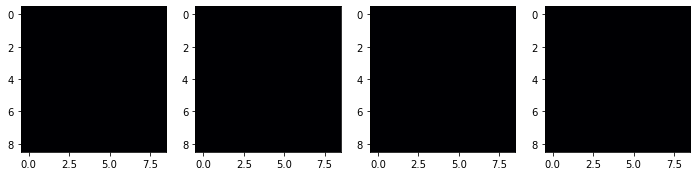

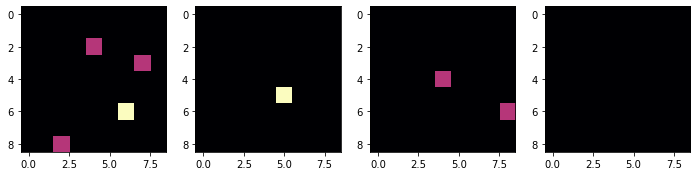

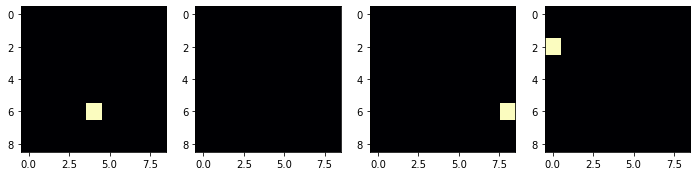

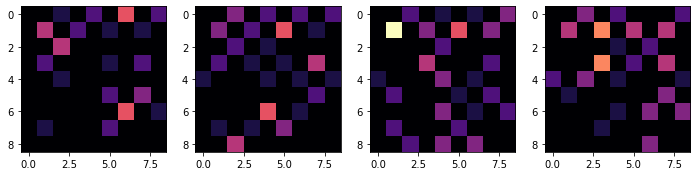

In [ ]:
int_5 = np.arange(0, 2160, 4)
int_10 = np.arange(1, 2160, 4)
int_15 = np.arange(2, 2160, 4)
int_20 = np.arange(3, 2160, 4)

for chan in range(84):
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    actis = []
    for i, intensity in enumerate([int_5, int_10, int_15, int_20]):
        leds_b, leds = [], []
        array_leds, array_leds_b = np.zeros((9, 9)), np.zeros((9, 9))
        for led in intensity:
            leds.append(len(presentation[led][chan]))
            leds_b.append(len(baselines[led][chan]))
    
        leds = np.array(leds).reshape(15, 36)
        leds_b = np.array(leds_b).reshape(15, 36)

        leds = np.mean(leds, axis=0)
        leds_b = np.mean(leds_b, axis=0)

        for l, c in zip(leds, coords):
            array_leds[c[0], c[1]] = l
        
        for l, c in zip(leds_b, coords):
            array_leds_b[c[0], c[1]] = l


        actis.append((array_leds - array_leds_b).reshape(9, 9))
    actimax = np.max(actis)
    axs[0].imshow(actis[0], vmin=0, vmax=actimax, cmap='magma')
    axs[1].imshow(actis[1], vmin=0, vmax=actimax, cmap='magma')
    axs[2].imshow(actis[2], vmin=0, vmax=actimax, cmap='magma')
    axs[3].imshow(actis[3], vmin=0, vmax=actimax, cmap='magma')

    plt.show()
    plt.close()

In [ ]:
# Faire PSTH sur les canaux intéressant. pour toutes les leds, tous les points

In [ ]:
channel = 64
int_5 = np.arange(0, 2160, 4)
int_10 = np.arange(1, 2160, 4)
int_15 = np.arange(2, 2160, 4)
int_20 = np.arange(3, 2160, 4)

# Courbe temps d'activation en fonction du temps avec binnage de 25 ms

for i, intensity in enumerate([int_5, int_10, int_15, int_20]):
    leds = []
    array_leds, array_leds_b = np.zeros((9, 9)), np.zeros((9, 9))
    for led in intensity:
        print(presentation[led][64])


[24.85]
[]
[24.5]
[25.05]
[]
[26.65]
[]
[]
[25.4]
[25.3]
[]
[26.45]
[25.65]
[]
[]
[24.95]
[25.15]
[24.7]
[24.8]
[25.]
[24.25]
[25.55]
[]
[]
[24.5]
[]
[25.3]
[25.]
[]
[]
[27.3]
[]
[]
[24.5]
[24.9]
[24.95]
[25.2]
[25.]
[25.6]
[25.3]
[]
[25.15]
[]
[24.9]
[24.75]
[]
[]
[24.2]
[25.45]
[24.95]
[24.95]
[25.3]
[25.9]
[25.6]
[25.1]
[]
[]
[24.95]
[24.6]
[]
[24.9]
[24.8]
[25.3]
[25.15]
[]
[24.65]
[]
[24.9]
[25.2]
[24.25]
[24.85]
[26.15]
[]
[25.5]
[24.6]
[25.45]
[25.45]
[24.7]
[]
[25.3]
[25.55]
[24.95]
[24.4]
[]
[25.55]
[]
[24.3]
[25.45]
[25.4]
[25.2]
[24.9]
[24.5]
[]
[25.6]
[24.95]
[24.7]
[25.1]
[]
[]
[]
[24.55]
[]
[]
[]
[25.1]
[]
[25.]
[]
[26.5]
[25.05]
[25.3]
[25.45]
[24.65]
[]
[]
[]
[25.25]
[25.25 25.3 ]
[25.1]
[24.45]
[]
[24.75]
[26.5]
[24.55]
[25.1]
[27.5]
[24.85]
[24.65]
[24.55]
[]
[25.]
[ 0.15 24.65]
[24.8]
[]
[]
[ 0.3  25.15]
[25.3]
[24.45]
[24.85]
[24.6]
[25.75]
[24.6]
[]
[25.95]
[]
[25.25]
[]
[24.75]
[ 0.35 49.9 ]
[ 0.25 24.65]
[]
[25.7]
[24.7]
[25.25]
[24.95]
[]
[25.35]
[24.9]
[ 0.35 2

In [ ]:
# Regarder par channel +++ car sinon les différences de spiking entre les sites de recording vont moyennes les rations d'upspiking

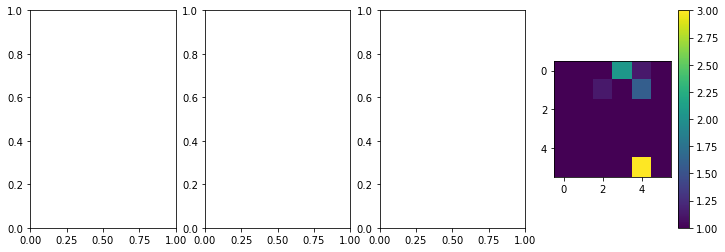

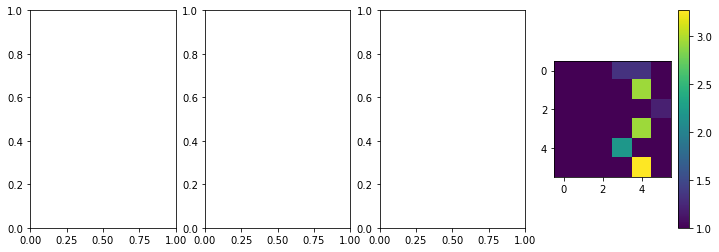

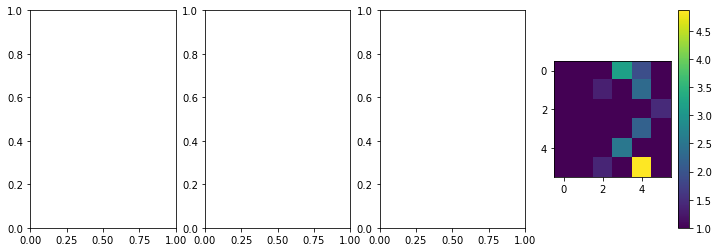

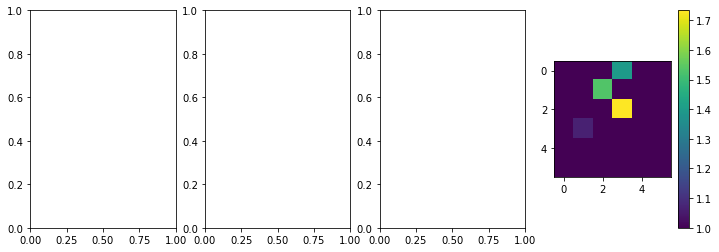

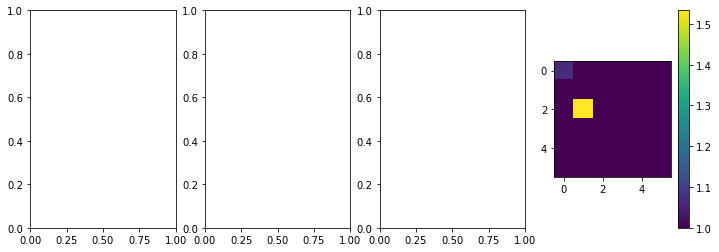

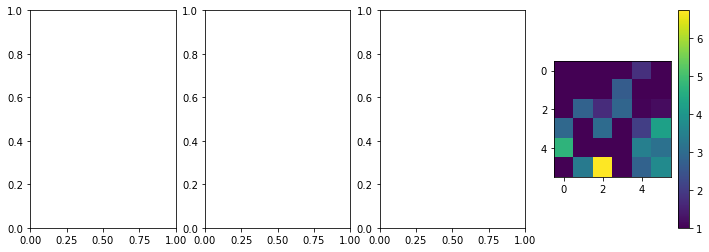

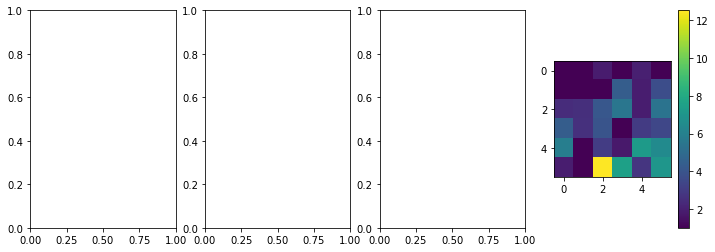

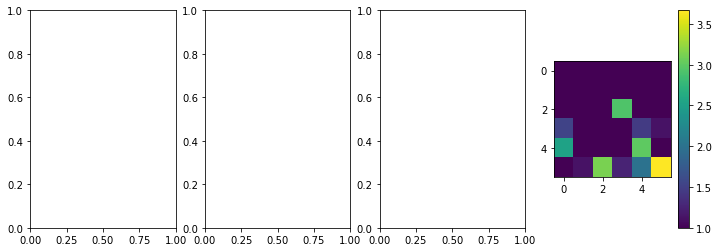

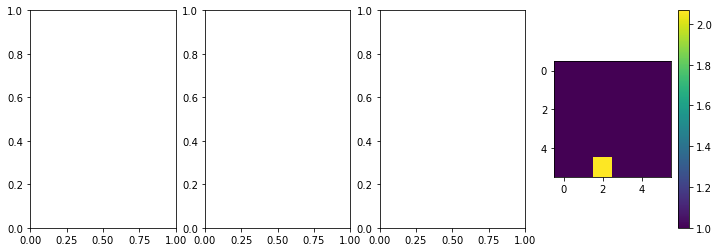

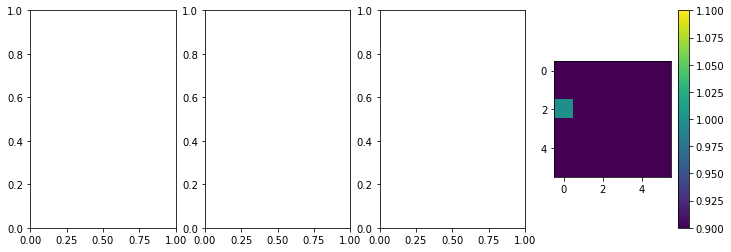

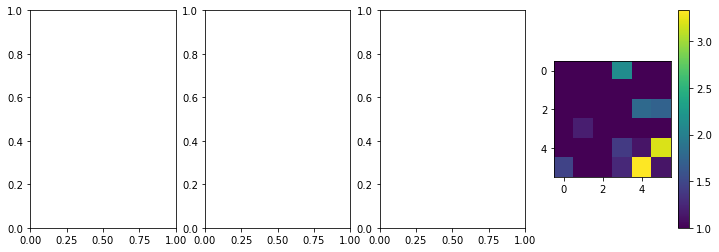

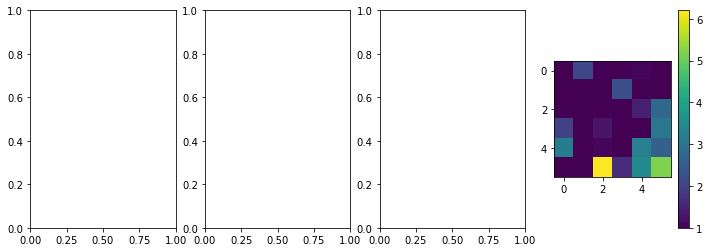

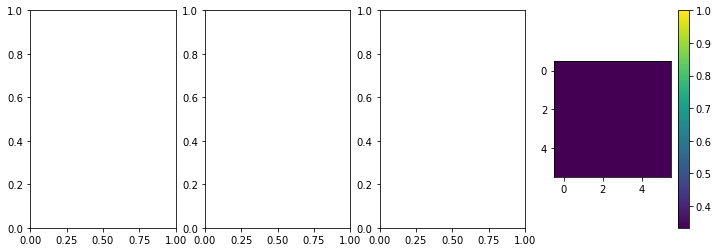

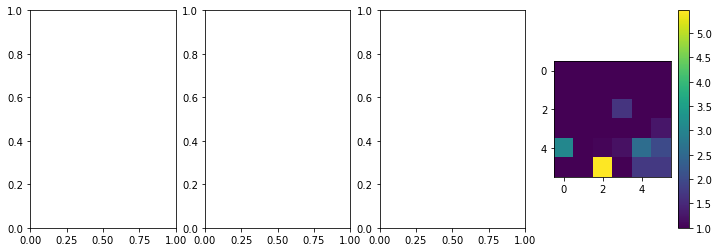

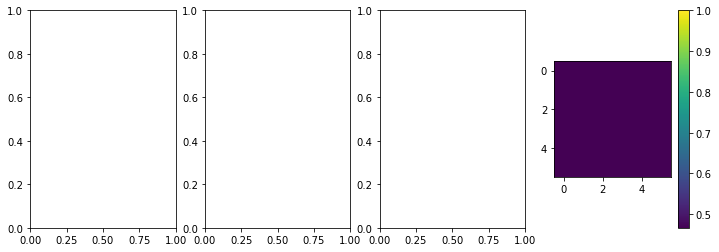

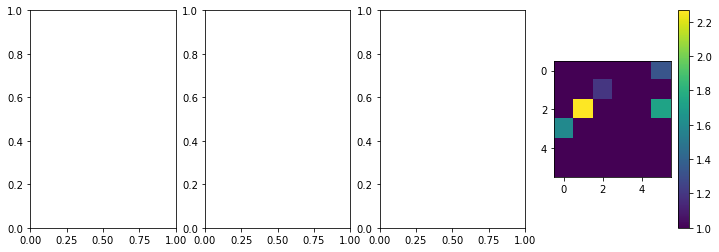

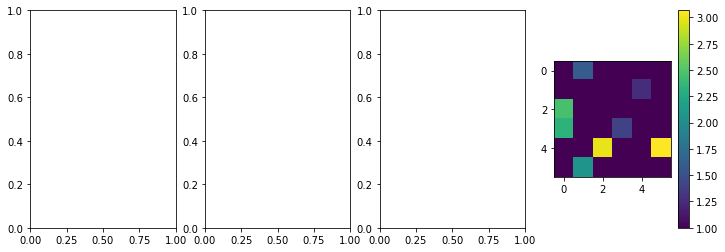

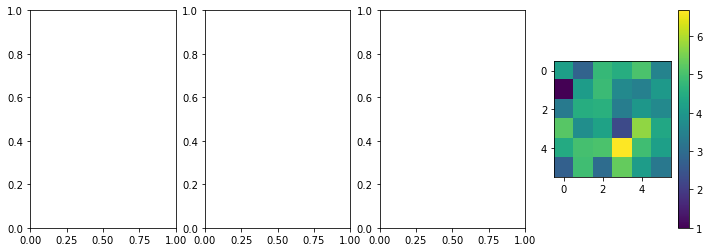

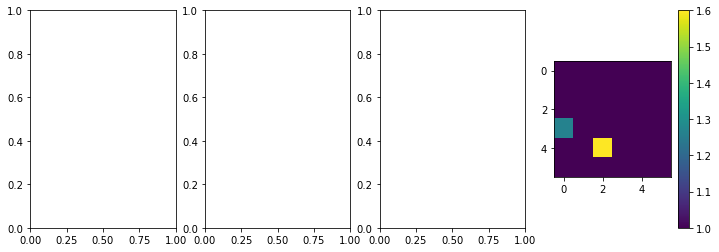

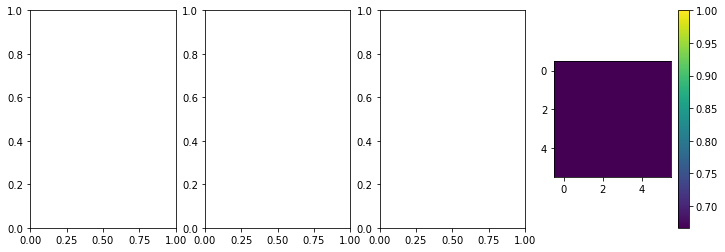

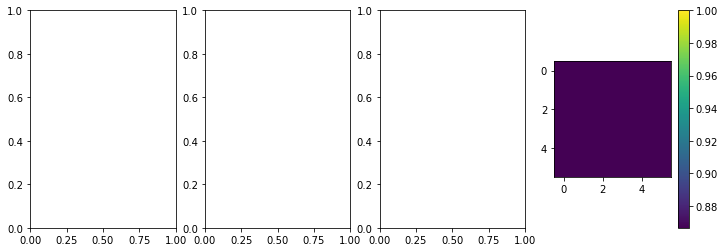

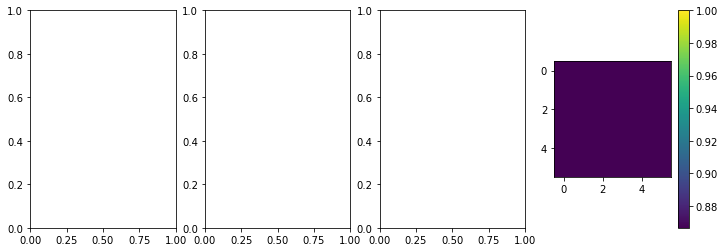

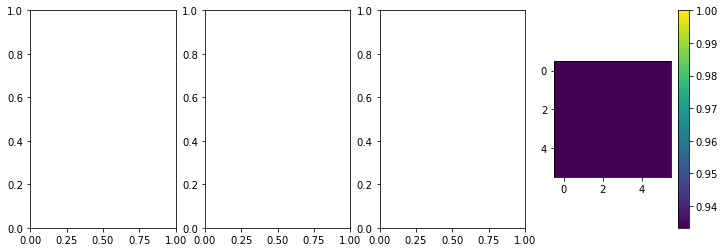

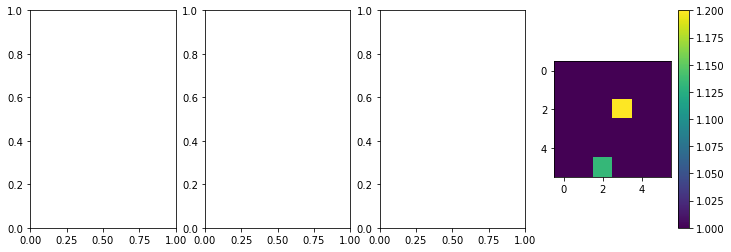

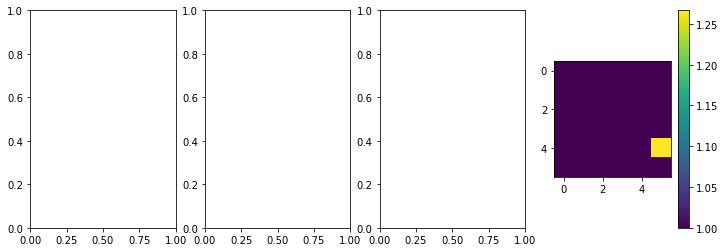

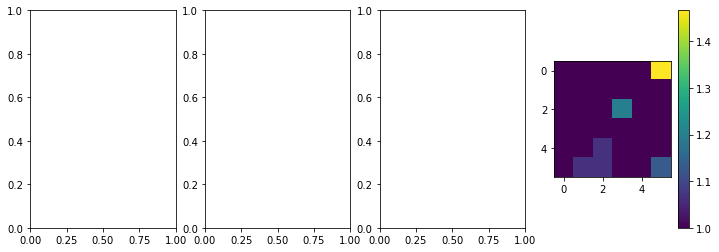

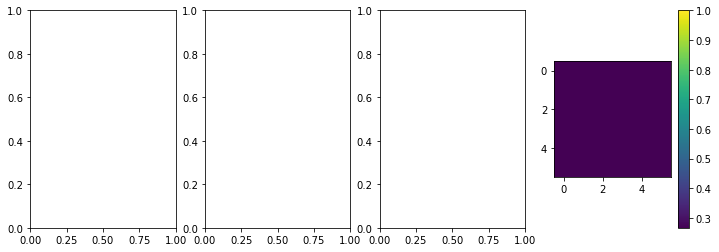

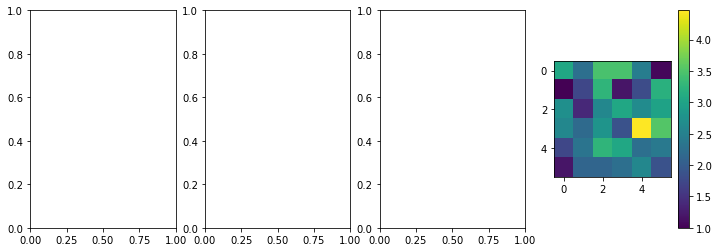

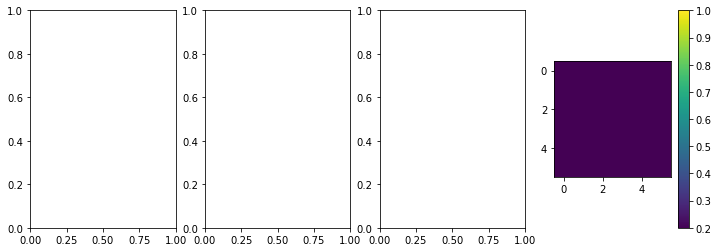

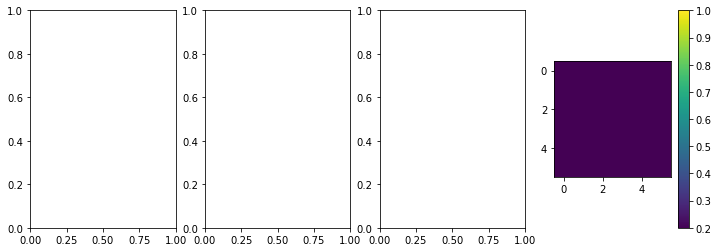

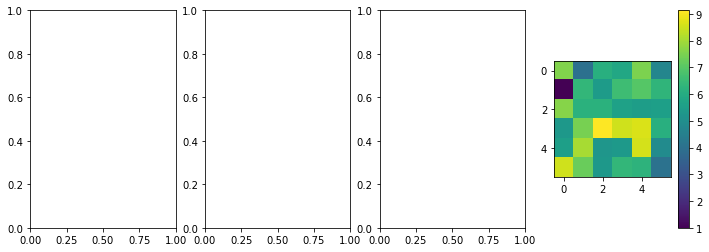

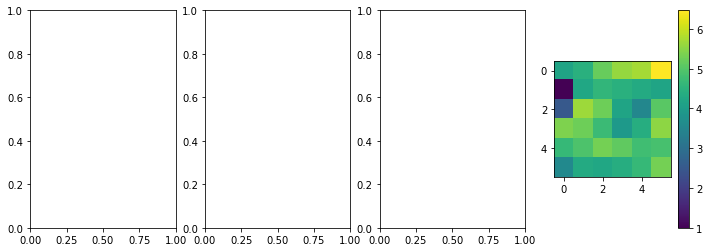

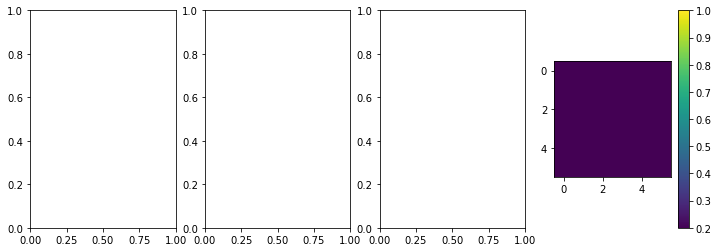

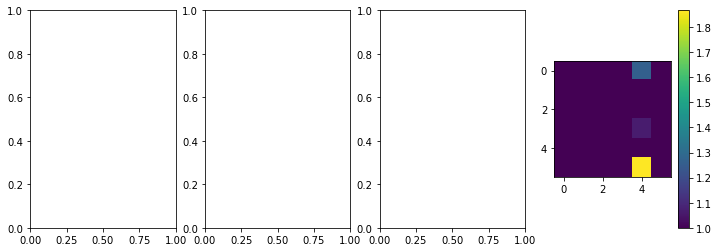

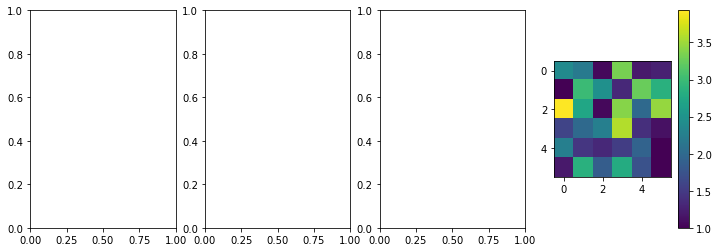

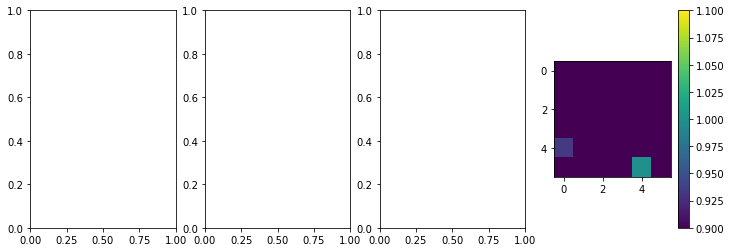

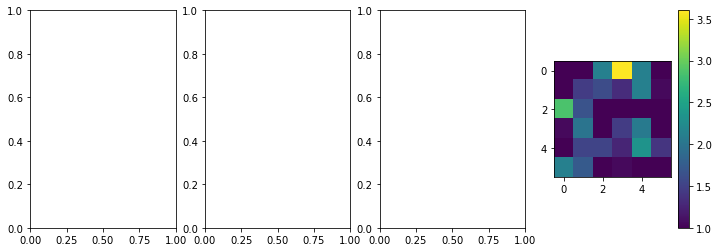

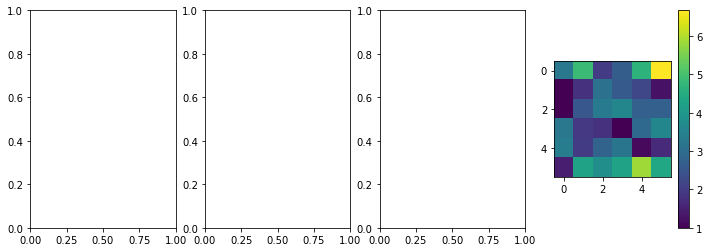

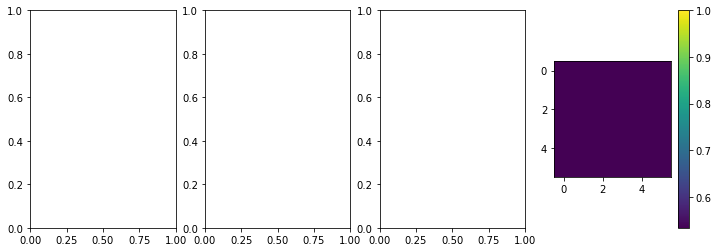

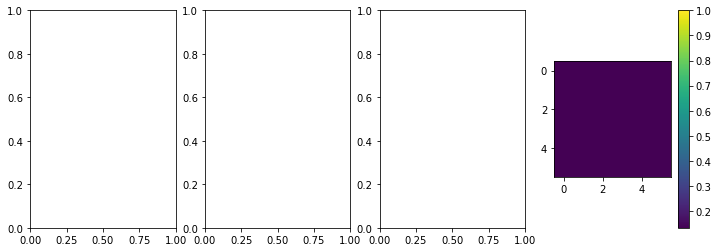

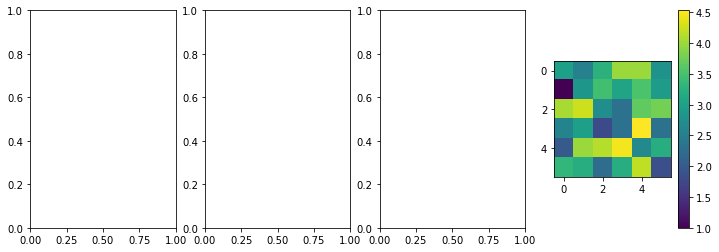

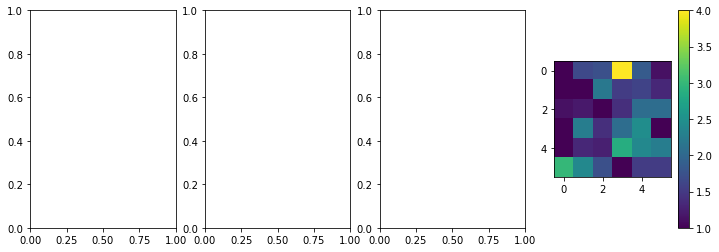

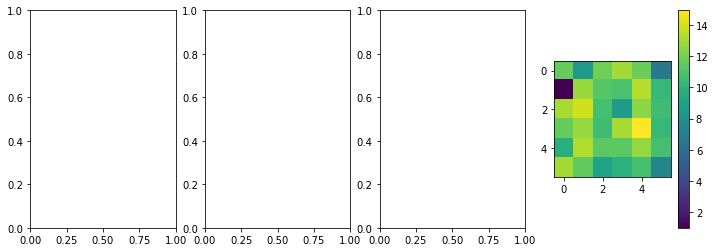

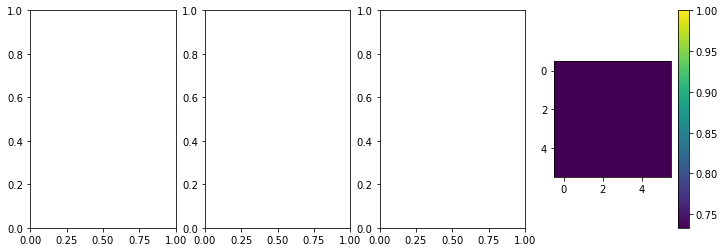

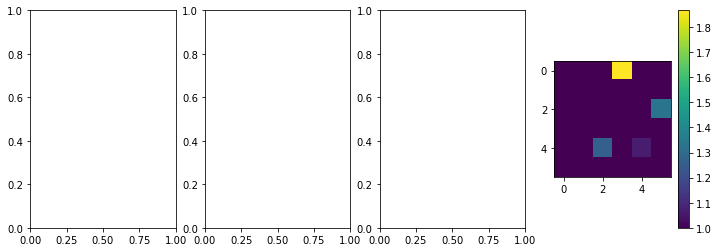

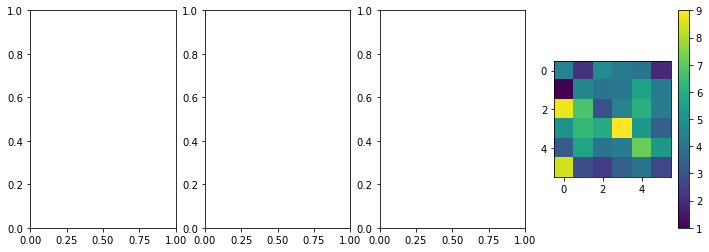

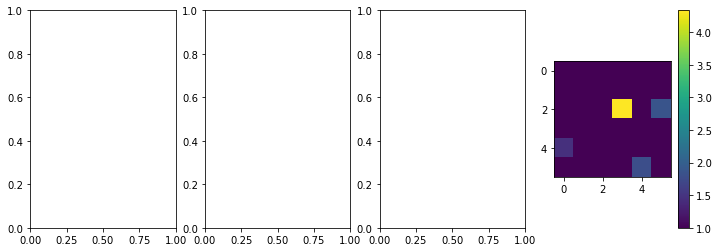

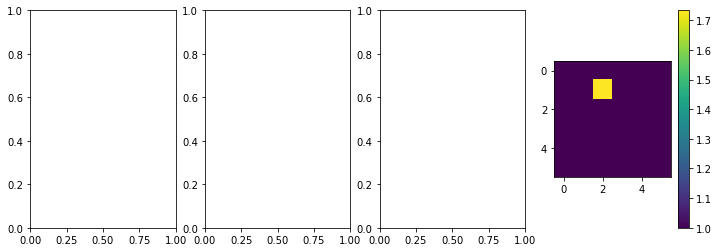

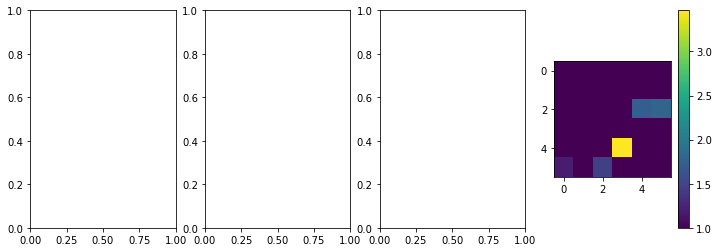

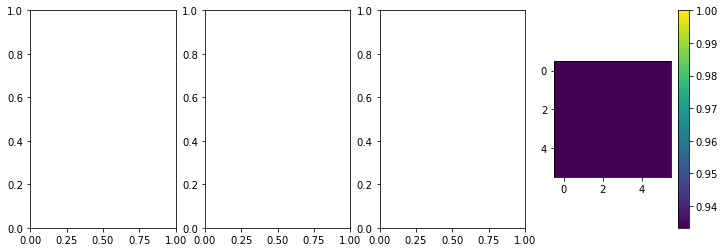

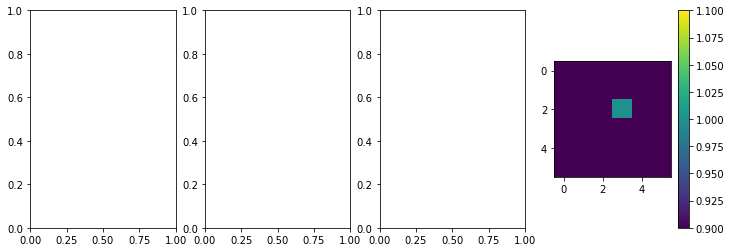

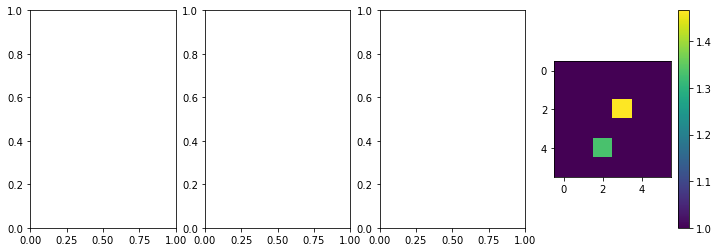

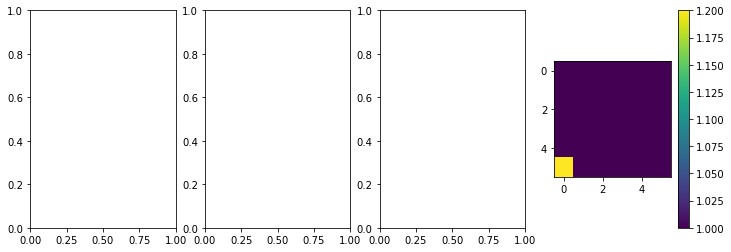

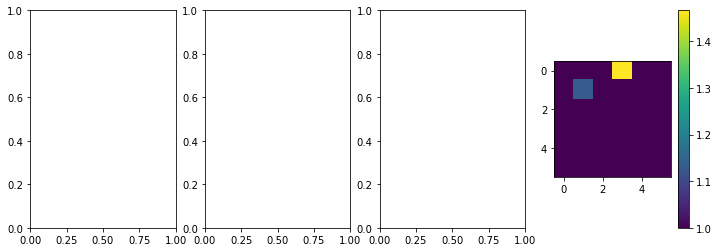

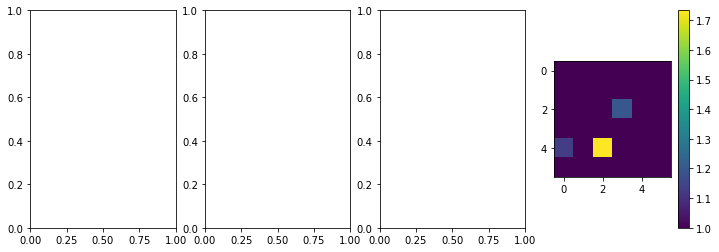

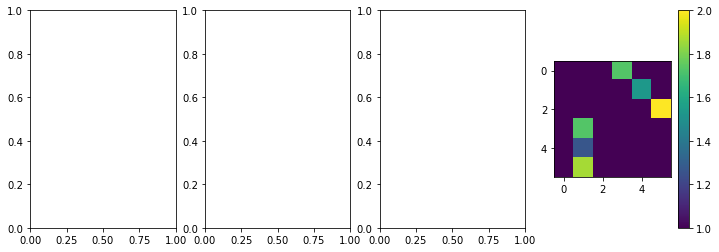

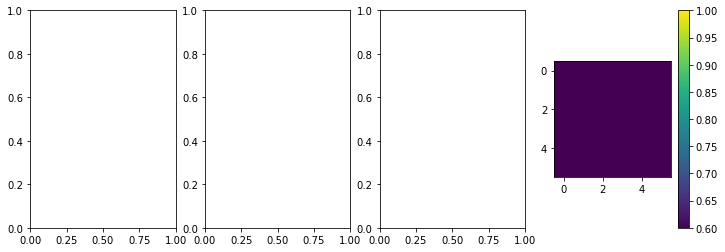

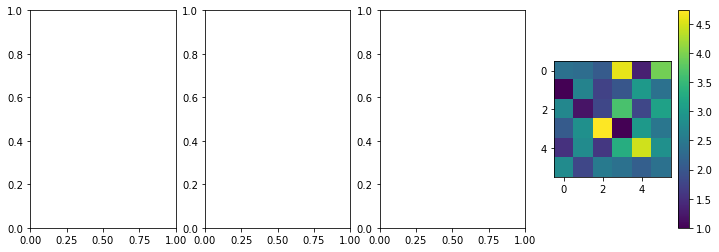

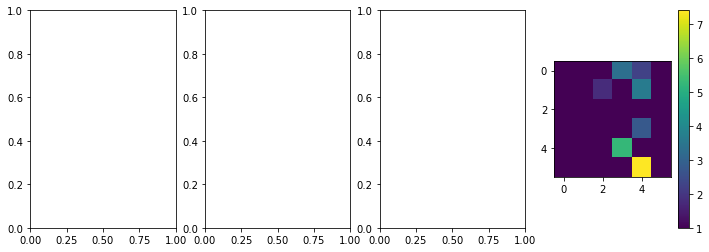

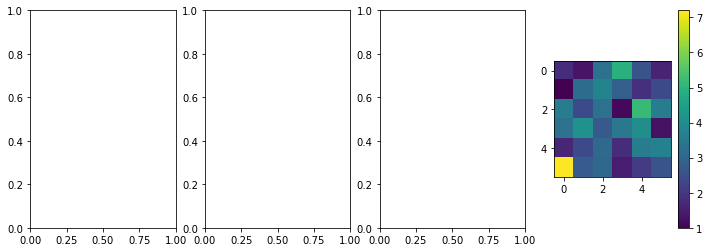

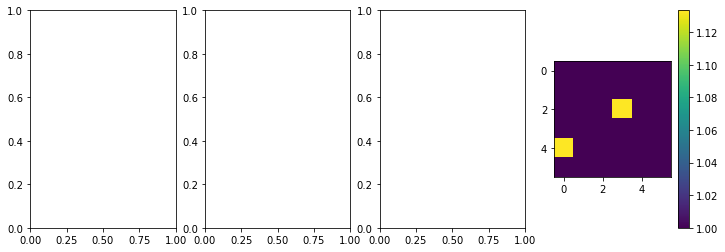

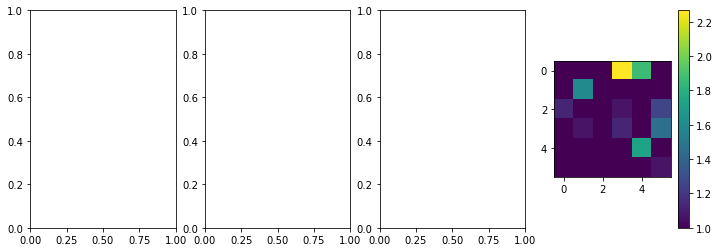

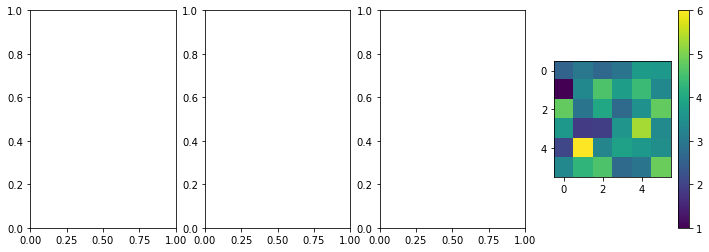

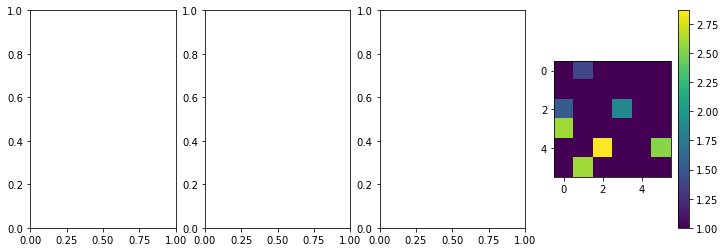

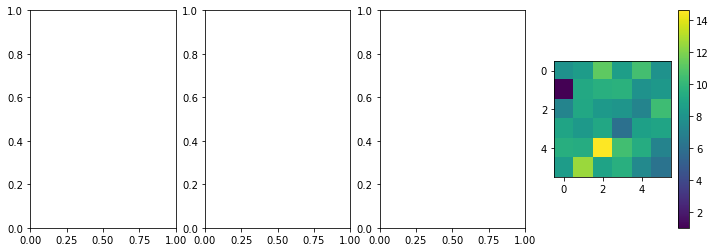

In [ ]:
int_5 = np.arange(0, 2160, 4)
int_10 = np.arange(1, 2160, 4)
int_15 = np.arange(2, 2160, 4)
int_20 = np.arange(3, 2160, 4)

for chan in range(65):
    leds_b, leds = [], []
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    for led in int_20:
        leds.append(len(presentation[led][chan]))
        leds_b.append(len(baselines[led][chan]))
    


    leds = np.array(leds).reshape(15, 36)
    leds_b = np.array(leds_b).reshape(15, 36)

    leds = np.mean(leds, axis=0)
    leds_b = np.mean(leds_b, axis=0)

    acti = (leds - leds_b).reshape(6, 6)
    plt.imshow(acti, vmin=1)
    plt.colorbar()
    plt.show()
    plt.close()



In [ ]:
for k in range(144):
    print(np.sum([len(mean_pres[k][c]) for c in range(n_chan)]))

2150
2227
2456
2477
2662
2154
2249
2141
2656
2541
2479
2045
2741
2813
2455
2870
2508
2272
2436
2623
2319
2133
2096
2131
1617
1369
1743
1209
2630
2688
2665
2372
2507
2835
2819
2530
2354
3010
2438
2746
2859
2937
2563
2721
2544
2689
2617
2609
2554
3089
3167
2773
2798
2635
2676
2652
2509
2540
2310
2527
3049
2735
2457
3044
2477
2878
2793
2651
2889
2748
2675
2790
2601
2698
2666
2692
2523
2733
2815
2655
2637
2416
2673
2875
2635
2795
2589
2371
2467
2889
2429
2973
2714
2550
2864
2682
2706
2748
2531
2881
3051
2965
2595
2781
2856
2521
2342
2884
2754
2559
2763
2790
2861
3186
3222
2795
2858
2897
2719
2776
2630
2700
2416
2850
2283
2914
2861
2616
2471
3178
2864
2940
2457
2445
2618
2653
2202
2408
2287
2990
2472
2923
3095
2811


In [ ]:
int_5 = np.arange(0, 144, 4)
int_10 = np.arange(1, 144, 4)
int_15 = np.arange(2, 144, 4)
int_20 = np.arange(3, 144, 4)

In [ ]:
intensities = [int_5, int_10, int_15, int_20]
name_protocol = ['5mW', '10mW', '15mW', '20mW']
for c in range(n_chan):
    #fig, axs = plt.subplots(1, 4)
    evo_spike = []
    for i, intensity in enumerate(intensities):
        heat = np.array([len(mean_pres[led][c]) for led in intensity]).reshape(6, 6)
        evo_spike.append(np.max([len(mean_pres[led][c])for led in intensity])/np.max([len(mean_pres[led][c])for led in int_5]))
    plt.plot(evo_spike)
    plt.savefig('implant_heatmaps/mean_channels_{}.png'.format(c))
    plt.close()

    #     axs[i].imshow(heat)
    #     axs[i].set_title('{}'.format(name_protocol[i]))
    # plt.savefig('implant_heatmaps/channel_{}.png'.format(c))
    # plt.close()


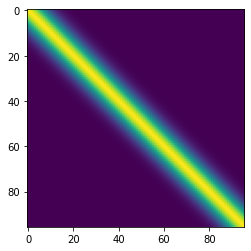

In [ ]:
t = np.load('/home/anverdie/share/gaia/User_folders/Antonin/topelitz_gaussian_cxe_28k.npy', allow_pickle=True)
plt.imshow(t)
plt.savefig('gaussian.svg')